Dataset loaded successfully!
   male  age  education  currentSmoker  cigsPerDay  BPMeds  prevalentStroke  \
0     1   39        4.0              0         0.0     0.0                0   
1     0   46        2.0              0         0.0     0.0                0   
2     1   48        1.0              1        20.0     0.0                0   
3     0   61        3.0              1        30.0     0.0                0   
4     0   46        3.0              1        23.0     0.0                0   

   prevalentHyp  diabetes  totChol  sysBP  diaBP    BMI  heartRate  glucose  \
0             0         0    195.0  106.0   70.0  26.97       80.0     77.0   
1             0         0    250.0  121.0   81.0  28.73       95.0     76.0   
2             0         0    245.0  127.5   80.0  25.34       75.0     70.0   
3             1         0    225.0  150.0   95.0  28.58       65.0    103.0   
4             0         0    285.0  130.0   84.0  23.10       85.0     85.0   

   TenYearCHD  
0    

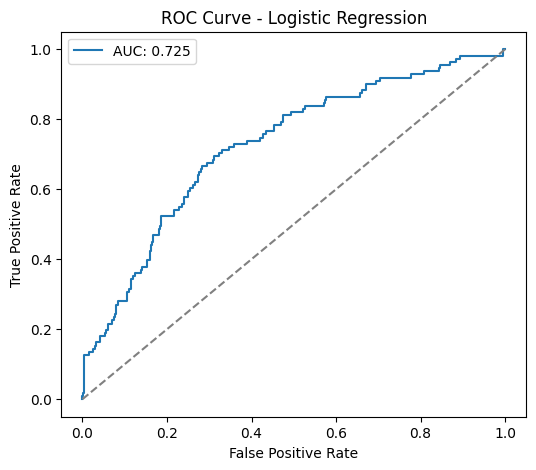

Random Forest AUC: 0.7035
Best parameters: {'n_estimators': 400, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 6, 'class_weight': None}


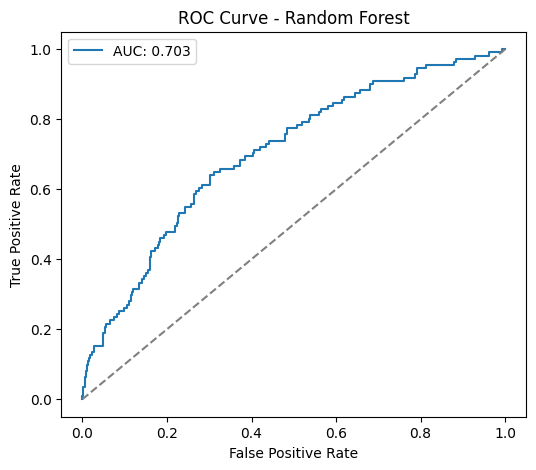

XGBoost AUC: 0.7193
Best parameters: {'subsample': 0.7, 'scale_pos_weight': 1, 'n_estimators': 400, 'max_depth': 3, 'learning_rate': 0.01, 'colsample_bytree': 0.7}


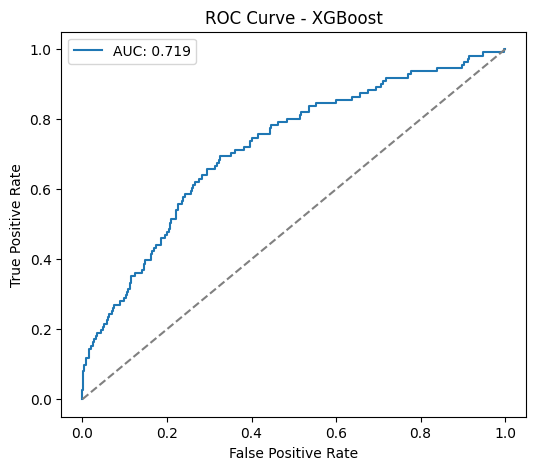

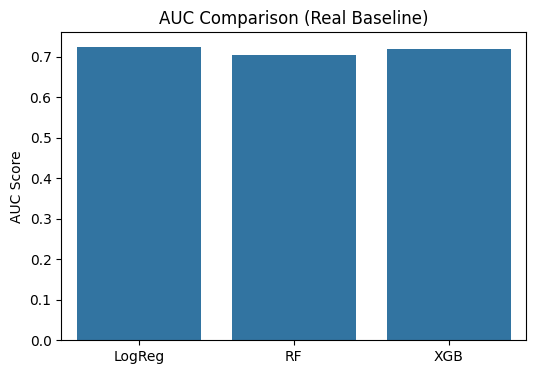

--- MODEL COMPARISON ---
Logistic Regression AUC: 0.7246
Random Forest AUC:        0.7035
XGBoost AUC:              0.7193
 ✔ REAL baseline completed!


In [9]:
#!/usr/bin/env python
# coding: utf-8

# --- REAL BASELINE NOTEBOOK (ENGLISH VERSION) ---
# Models: Logistic Regression, Random Forest, XGBoost
# Includes: Train/Test split, proper scaling, tuning, imbalance handling,
# and plots for evaluation.

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score, classification_report, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import warnings

# ------------------------------------------------------
# 1. Load cleaned dataset
# ------------------------------------------------------
file_path = "../data/processed/framingham_clean.csv"
df = pd.read_csv(file_path)

print("Dataset loaded successfully!")
print(df.head())

# ------------------------------------------------------
# 2. Separate features and target
# ------------------------------------------------------
target = "TenYearCHD"
X = df.drop(columns=[target])
y = df[target]

# ------------------------------------------------------
# 3. Train/Test Split (Stratified for class balance)
# ------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ------------------------------------------------------
# 4. Scaling numerical features (fit ONLY on train)
# ------------------------------------------------------
numerical_cols = X.select_dtypes(include=["float64", "int64"]).columns

scaler = MinMaxScaler()
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

# ------------------------------------------------------
# Utility: ROC Curve Plot
# ------------------------------------------------------
def plot_roc(model_name, y_test, y_scores):
    fpr, tpr, _ = roc_curve(y_test, y_scores)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f"AUC: {roc_auc_score(y_test, y_scores):.3f}")
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.title(f"ROC Curve - {model_name}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show()

# ------------------------------------------------------
# 5. Logistic Regression + tuning
# ------------------------------------------------------
# Explanation:
# - C controls regularization strength (smaller = stronger regularization)
# - class_weight="balanced" helps with imbalanced targets

log_params = {
    "C": np.logspace(-3, 2, 10),
    "penalty": ["l2"],
    "class_weight": ["balanced", None]
}

log_clf = RandomizedSearchCV(
    estimator=LogisticRegression(max_iter=500, solver="lbfgs"),
    param_distributions=log_params,
    n_iter=10,
    scoring="roc_auc",
    cv=5,
    random_state=42,
    n_jobs=-1
)

log_clf.fit(X_train, y_train)
log_pred = log_clf.predict_proba(X_test)[:, 1]
log_auc = roc_auc_score(y_test, log_pred)

print(f"Logistic Regression AUC: {log_auc:.4f}")
print("Best parameters:", log_clf.best_params_)
plot_roc("Logistic Regression", y_test, log_pred)

# ------------------------------------------------------
# 6. Random Forest + tuning
# ------------------------------------------------------
# Key hyperparameters:
# - max_depth: tree complexity
# - min_samples_leaf: improves generalization
# - class_weight: handles imbalance

rf_params = {
    "n_estimators": [200, 400, 600],
    "max_depth": [4, 6, 8, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "class_weight": ["balanced", None],
    "max_features": ["sqrt", "log2"]
}

rf_clf = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_distributions=rf_params,
    n_iter=20,
    scoring="roc_auc",
    cv=5,
    random_state=42,
    n_jobs=-1
)

rf_clf.fit(X_train, y_train)
rf_pred = rf_clf.predict_proba(X_test)[:, 1]
rf_auc = roc_auc_score(y_test, rf_pred)

print(f"Random Forest AUC: {rf_auc:.4f}")
print("Best parameters:", rf_clf.best_params_)
plot_roc("Random Forest", y_test, rf_pred)

# ------------------------------------------------------
# 7. XGBoost + tuning
# ------------------------------------------------------
# Key parameters:
# - learning_rate: controls how fast the model learns
# - max_depth: controls tree complexity
# - subsample/colsample_bytree: help avoid overfitting
# - scale_pos_weight: handles class imbalance

xgb_params = {
    "max_depth": [3, 4, 5],
    "learning_rate": [0.01, 0.05, 0.1],
    "n_estimators": [200, 400],
    "subsample": [0.7, 0.9, 1.0],
    "colsample_bytree": [0.7, 0.9, 1.0],
    "scale_pos_weight": [1, 2, 5]
}


warnings.filterwarnings("ignore", category=UserWarning)

xgb_model = xgb.XGBClassifier(
    eval_metric="logloss",
    random_state=42
)


xgb_clf = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=xgb_params,
    n_iter=20,
    scoring="roc_auc",
    cv=5,
    random_state=42,
    n_jobs=-1
)

xgb_clf.fit(X_train, y_train)
xgb_pred = xgb_clf.predict_proba(X_test)[:, 1]
xgb_auc = roc_auc_score(y_test, xgb_pred)

print(f"XGBoost AUC: {xgb_auc:.4f}")
print("Best parameters:", xgb_clf.best_params_)
plot_roc("XGBoost", y_test, xgb_pred)

# ------------------------------------------------------
# 8. Summary Comparison
# ------------------------------------------------------
plt.figure(figsize=(6, 4))
model_names = ["LogReg", "RF", "XGB"]
auc_values = [log_auc, rf_auc, xgb_auc]
sns.barplot(x=model_names, y=auc_values)
plt.title("AUC Comparison (Real Baseline)")
plt.ylabel("AUC Score")
plt.show()

print("--- MODEL COMPARISON ---")
print(f"Logistic Regression AUC: {log_auc:.4f}")
print(f"Random Forest AUC:        {rf_auc:.4f}")
print(f"XGBoost AUC:              {xgb_auc:.4f}")
print(" ✔ REAL baseline completed!")


In [11]:
# ------------------------------------------------------
# 9. Save results to model_results.csv
# ------------------------------------------------------
import os

results_path = "../data/results/model_results.csv"

baseline_real = pd.DataFrame([
    {"method": "real", "model": "Logistic Regression", "auc": log_auc},
    {"method": "real", "model": "Random Forest", "auc": rf_auc},
    {"method": "real", "model": "XGBoost", "auc": xgb_auc},
])

# Append or create file safely
if os.path.exists(results_path):
    try:
        old = pd.read_csv(results_path)
        updated = pd.concat([old, baseline_real], ignore_index=True)
    except Exception:
        # File exists but is empty or unreadable → recreate from scratch
        updated = baseline_real
    updated.to_csv(results_path, index=False)
else:
    baseline_real.to_csv(results_path, index=False)

print("📁 Real baseline results saved to data/results/model_results.csv")


📁 Real baseline results saved to data/results/model_results.csv



# Interpretation of Baseline Model Results


## 1. Overall Performance
All three models—Logistic Regression, Random Forest, and XGBoost—achieve AUC scores between **0.70 and 0.73**. These values indicate moderate discriminative ability. This level of performance is expected for the Framingham dataset, which contains noisy clinical variables, moderate class imbalance, and relatively weak predictors.


## 2. Logistic Regression (AUC ≈ 0.7246)
Logistic Regression performs slightly better than the tree-based models, suggesting:
- The relationship between variables and the target is mostly linear or monotonic.
- Regularization and class weighting help stabilize performance.
- Simpler models may generalize better on this dataset.


## 3. Random Forest (AUC ≈ 0.7035)
Random Forest achieves the lowest AUC among the three models. Reasons may include:
- Limited nonlinear interactions in the dataset.
- Moderate overfitting despite tuning.
- Correlated features reducing tree diversity.


## 4. XGBoost (AUC ≈ 0.7193)
XGBoost performs slightly better than RF and slightly worse than Logistic Regression, indicating:
- Some nonlinear structure exists, but not enough to strongly outperform linear models.
- Boosting benefits from tuning but still faces dataset noise.


## 5. Comparative Ranking
1. Logistic Regression (~0.725)
2. XGBoost (~0.719)
3. Random Forest (~0.703)


The small differences confirm that model choice is less important than the inherent dataset limitations.

